## Initialize a new Chat

In [1]:
from intellitube.utils import ChatManager
chat: ChatManager = ChatManager.new_chat()
print(f"Chat ID:", chat.chat_id)
chat.remove_unlisted_chats()

ModuleNotFoundError: No module named 'loguru'

## Initialize the RAG System
Using `TextDocumentRAG()` from `intellitube.rag` module automatically initializes `Qdrant` client as Vector Database.

In [2]:
import os
from typing import List
from intellitube.rag import TextDocumentRAG
from langchain_core.documents import Document

document_rag = TextDocumentRAG(
    path_on_disk=chat.chat_dirpath,
    collection_path_on_disk=os.path.join(chat.chat_dirpath, "collection"),
    collection_name=chat.chat_id,
)

def add_to_vdb(docuemnts: List[Document]) -> None:
    # convert to a list of document(s) if not already!
    if type(docuemnts) == Document:
        docuemnts = [docuemnts]
    
    document_rag.add_documents(
        docuemnts, split_text=True,
        split_config={
            "chunk_size": 512,
            "chunk_overlap": 128
        },
        skip_if_collection_exists=True,
    )

2025-07-11 12:37:30.126 | DEBUG    | intellitube.rag:init_vector_store:66 - Creaing Client...
2025-07-11 12:37:30.138 | DEBUG    | intellitube.rag:init_vector_store:73 - Creaing vector store


## Create Document Loader Tools

In [3]:
from langchain.tools import tool
from loguru import logger

### 1. Add YouTube Videos to the Vector Database

In [ ]:
from intellitube.utils import (
    YTContentData,
    webvtt_2_str,
    download_youtube_audio_or_transcript,
)

test_url = "https://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s"

def load_youtube_transcript(youtube_url: str) -> bool:
    """Load the given YouTube video's transcript to the vector database.
    It is required to answer user-queries based on the the Transcript context."""
    try:
        logger.debug("Loading Youtube Transcript...")
        
        # download the youtube transcript (or audio if transcript not available)
        yt_video_data: YTContentData = download_youtube_audio_or_transcript(
            video_url=youtube_url,
        )

        # convert the WEBVTT format trancript to a plain text string
        vtt_str = webvtt_2_str(vtt_file_path=yt_video_data.transcript_path)
        
        logger.debug(vtt_str[:100])    # print first 100 characters

        # add the transcript-string to the vector database
        add_to_vdb(Document(vtt_str))
    except Exception as e:
        logger.error(str(e))
        return False
    return True

### 2. Add PDF/Text Documents to the Vector Dataabse

In [5]:
import os
from langchain_community.document_loaders import PyPDFLoader

def load_document(document_path: str) -> bool:
    """Load the given Document's content to the vector database.
    It is required to answer user-queries based on the the Document context."""

    try:
        logger.debug("Loading Document...")
        
        ext = os.path.splitext(document_path)[1][1:].lower()
        documents: List[Document]

        if ext == 'pdf':
            documents = PyPDFLoader(document_path).load()
        elif ext in ['txt', 'py']:
            with open(document_path, 'r') as file:
                documents = [Document(
                    page_content=file.read(),
                    metadata={ "source": document_path }
                )]
        else:
            return False
        
        add_to_vdb(documents)
    except Exception as e:
        logger.error(str(e))
        return False
    return True
        

### 3. Add WebPages as Documents to the Vector Database

In [6]:
from langchain_community.document_loaders import WebBaseLoader

def load_webpage(webpage_url: str) -> bool:
    """Load the given WebSite's content to the vector database.
    It is required to answer user-queries based on the the WebPage's context."""

    try:
        add_to_vdb(WebBaseLoader(webpage_url).load())
        logger.debug("Loading Webpage...")
    except Exception as e:
        logger.error(str(e))
        return False
    return True
    

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Document Loader Function Dictionary

In [7]:
document_loader_functions = {
    "document": load_document,
    "youtube_video": load_youtube_transcript,
    "website": load_webpage
}

## Choose an LLM

In [1]:
from typing import Literal, Optional
# from langchain.chat_models import init_chat_model
from langchain_core.language_models import BaseChatModel

from dotenv import load_dotenv
load_dotenv()

def init_llm(
    model_provider: Literal['openai', 'groq', 'nvidia', 'google', 'ollama'],
    model_name: Optional[str] = None,
    temperature: float = 0.0,
) -> BaseChatModel:
    if model_provider == 'openai':
        from langchain_openai import ChatOpenAI
        return ChatOpenAI(model=model_name or "gpt-4o-mini", temperature=temperature)
    elif model_provider == 'groq':
        from langchain_groq import ChatGroq
        return ChatGroq(model=model_name or "llama-3.3-70b-versatile", temperature=temperature)
    elif model_provider == 'nvidia':
        from langchain_nvidia_ai_endpoints import ChatNVIDIA
        return ChatNVIDIA(model=model_name or "mistralai/mistral-small-24b-instruct", temperature=temperature)
        # return ChatNVIDIA(model=model_name or "nvidia/llama-3.1-nemotron-51b-instruct", temperature=temperature)
    elif model_provider == 'google':
        from langchain_google_genai import ChatGoogleGenerativeAI
        return ChatGoogleGenerativeAI(model=model_name or "gemini-2.0-flash", temperature=temperature, api_key=None)
    elif model_provider == 'ollama':
        from langchain_ollama import ChatOllama
        # return ChatOllama(model=model_name or "granite3.3:8b", temperature=temperature)
        return ChatOllama(model=model_name or "llama3.2:3b", temperature=temperature)
    
    raise ValueError(f"Invalid model_provider: {model_provider}")

#### Test the LLM

In [2]:
TEST_LLM = True
llm = init_llm(model_provider='google')
# llm = select_llm(model_provider='groq')
# llm = select_llm(model_provider='ollama')

if TEST_LLM:
    resp = llm.invoke("What is superiority complex? Respond with a nicely structured & formatted answer!")
    print(resp)
    
    from IPython.display import display, Markdown
    display(Markdown(resp.content))

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

## Define State Schema

### Router Agent Response State Schema

In [10]:
from pydantic import BaseModel, Field
from typing_extensions import Any, Optional
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage, BaseMessage

class RouterAgentResponse(BaseModel):
    user_query: str = Field(description=(
        "The user's original query EXACTLY as it appears, without any modification, rewording, or interpretation.\n"
        "You MUST NOT include any URLs, file paths, or hyperlinks in this field — only the natural language query.\n"
        "Preserve the casing, punctuation, and wording. Do NOT fix typos or grammar."
    ))
    url: Optional[str] = Field(default=None, description=(
        "The exact URL or local document/file path mentioned in the user's input.\n"
        "If there is no URL or file path, leave this as null (do not fabricate one).\n"
        "Example: 'https://example.com/page', 'C:/Documents/myfile.txt', './notes.md'"
    ))
    url_of: Optional[Literal["youtube_video", "website", "document"]] = Field(default=None, description=(
        "The type of content the `url` field refers to:\n"
        "- 'youtube_video': if it's a YouTube video link\n"
        "- 'website': for general websites or web pages\n"
        "- 'document': for file paths (like .txt, .pdf, .md, etc.)\n"
        "If no URL/path is provided, this should be null."
    ))

### Messages State Schema

In [11]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing_extensions import Annotated, Sequence, TypedDict, Optional

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    router_response: Optional[RouterAgentResponse] = None
    retrieved_docs: Optional[List[Document]] = None

## Create Nodes

### Router Node
This router will decide if the user has provided any Document/Website URL/YouTube URL. Depending on the type of URL it will call a function to load the document or just redirect the query to a RAG Agent for direct response generation if no URL is provided.

### 💡 Idea Behind Router Agent
The Router Agent will take the query and identify below mentioned features from the query:
 - User Query
 - URL/Path of a file/website/youtube-video

And then it will return a structured output with the following informations:
 - `url`: URL/Path mentioned in the provided query (Can be `None` if absent)
 - `user_query`: The user query
 - `url_of`: `"website"`, `"youtube_video"`, `"document"`

#### Define The System Message

In [12]:
system_message = SystemMessage("""
You are an extraction agent. Your task is to return a JSON response in this exact format:

{
  "user_query": "<EXACT user query WITHOUT any URLs or paths>",
  "url": "<the full URL or local path if present, else null>",
  "url_of": "<one of 'youtube_video', 'website', or 'document' if URL/path is present, else null>"
}

⚠️ VERY STRICT RULES (follow them or your output is invalid):
1. DO NOT paraphrase, correct, or modify the user's query — copy it EXACTLY as it appears.
2. REMOVE all URLs and file paths from the `user_query`.
3. IF a URL or file path exists, assign it to the `url` field and classify it using `url_of`.
4. `url_of` MUST be one of: "youtube_video", "website", or "document". Never invent new types.
5. IF no URL/path is found, both `url` and `url_of` must be null or omitted.

====================
EXAMPLES:

# Example 1 (simple website URL):
Input: How to use LangChain structured output? https://docs.langchain.com/docs/structured_outputs
Output:
{
  "user_query": "How to use LangChain structured output?",
  "url": "https://docs.langchain.com/docs/structured_outputs",
  "url_of": "website"
}

# Example 2 (YouTube video link):
Input: Summarize this video https://www.youtube.com/watch?v=dQw4w9WgXcQ
Output:
{
  "user_query": "Summarize this video",
  "url": "https://www.youtube.com/watch?v=dQw4w9WgXcQ",
  "url_of": "youtube_video"
}

# Example 3 (file name with extension):
Input: Convert file.txt to JSON
Output:
{
  "user_query": "Convert file.txt to JSON",
  "url": "file.txt",
  "url_of": "document"
}

# Example 4 (multiple file paths — take only the one mentioned):
Input: I saved it in ./notes/lecture1.md. Please summarize.
Output:
{
  "user_query": "Please summarize.",
  "url": "./notes/lecture1.md",
  "url_of": "document"
}

# Example 5 (no URL or file path):
Input: You should stop wasting your time
Output:
{
  "user_query": "You should stop wasting your time"
}

# Example 6 (unclear context — do NOT assume):
Input: Read this https://mystery.link/something
Output:
{
  "user_query": "Read this",
  "url": "https://mystery.link/something",
  "url_of": "website"
}

# Example 7 (file path with Windows format):
Input: Please check C:\\Users\\Me\\Desktop\\data.csv
Output:
{
  "user_query": "Please check",
  "url": "C:\\Users\\Me\\Desktop\\data.csv",
  "url_of": "document"
}
====================

🧠 TIP: If you are unsure about the type of the `url`, classify based on the extension or domain. If no clue, default to "website".

NOW RETURN ONLY THE JSON OBJECT. Do NOT add explanations, comments, or markdown.
""")


#### Router Agent Node

In [13]:
def router_agent_node(state: AgentState) -> AgentState:
    structured_llm = llm.with_structured_output(RouterAgentResponse)
    agent_resp: RouterAgentResponse = structured_llm.invoke([system_message, state["messages"][-1]])

    # loader_func = document_loader_functions.get(agent_resp.url_of)
    # if loader_func:
        # data = 

    return {"messages": [HumanMessage(agent_resp.user_query)], "router_response": agent_resp}

#### Query Router Node

In [14]:
def query_router_node(state: AgentState) -> Literal["use_loader", "use_retriever"]:
    return "use_retriever" if not state["router_response"].url_of else "use_loader"

#### Document Loader Node

In [15]:
def document_loader_node(state: AgentState) -> Literal["success", "fail"]:
    logger.info(f'{state["router_response"] = }')
    loader_func = document_loader_functions.get(state["router_response"].url_of)
    logger.info(f"{loader_func = }")
    status = loader_func(state["router_response"].url)
    return "success" if status else "fail"

#### Retriever Node

In [16]:
retriever = document_rag.vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.6}
)

def document_retriever_node(state: AgentState) -> AgentState:
    state["retrieved_docs"] = retriever.invoke(state["router_response"].user_query)
    print("\n\n\n")
    print(state["retrieved_docs"], end='\n\n')
    return state

#### Test (if you want)

In [17]:
TEST_DOC_LOAD_ROUTER = False

if TEST_DOC_LOAD_ROUTER:
    queries = [
        # Website URL
        "What is the model name mentioned?\nhttps://build.nvidia.com/nvidia/llama-3_1-nemotron-51b-instruct",
        # YouTube URL
        "What do you see here?\nhttps://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s",
        # Local Document Path
        "Summarize this document: ~/data.json",
        # Just a normal Query
        "Why oranges are red and violates are blue?",
        "This asdj/klrt/1234.py file appears to be corrupted. Can you read it?"
    ]

    for i, query in enumerate(queries):
        print("-"*15, f"Test {i + 1}", "*"*15, end='\n\n')
        response = router_agent_node(user_query=query)
        print("\n\n")


TEST_ROUTER_NODE = True

if TEST_ROUTER_NODE:
    from langchain_core.messages import HumanMessage

    queries = [
        # Website URL
        "What is the model name mentioned?\nhttps://build.nvidia.com/nvidia/llama-3_1-nemotron-51b-instruct",
        # YouTube URL
        "What do you see here?\nhttps://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s",
        # Local Document Path
        "Summarize this document: ~/data.json",
        # Just a normal Query
        "Why oranges are red and violates are blue?",
        "This asdj/klrt/1234.py file appears to be corrupted. Can you read it?"
    ]

    for query in queries:
        print("Query:", query)
        state = AgentState(messages=[HumanMessage(query)])
        resp = router_agent_node(state)
        print(resp)
        # print(resp["messages"][0].model_dump_json())

Query: What is the model name mentioned?
https://build.nvidia.com/nvidia/llama-3_1-nemotron-51b-instruct
{'messages': [HumanMessage(content='What is the model name mentioned?', additional_kwargs={}, response_metadata={})], 'router_response': RouterAgentResponse(user_query='What is the model name mentioned?', url='https://build.nvidia.com/nvidia/llama-3_1-nemotron-51b-instruct', url_of='website')}
Query: What do you see here?
https://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s
{'messages': [HumanMessage(content='What do you see here?', additional_kwargs={}, response_metadata={})], 'router_response': RouterAgentResponse(user_query='What do you see here?', url='https://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s', url_of='youtube_video')}
Query: Summarize this document: ~/data.json
{'messages': [HumanMessage(content='Summarize this document:', additional_kwargs={}, response_metadata={})], 'router_response': RouterAgentResponse(user_query='Summarize this document:', url='~/data.json', url_of

### Chat Agent Node

In [ ]:
"""

Answer user query with within the given context. If the context -
    - Not Relevant: Ask for better context.
    - Not Found: Say politely you can't answer.

"""

def chat_agent_node(state: AgentState) -> AgentState:
    """A Chat Agent"""
    docs = (
        "\n\n".join(f"Source #{i + 1}: {document.page_content}" for i, document in enumerate(state["retrieved_docs"]))
        if state.get("retrieved_docs") else ""
    )

    system_prompt = SystemMessage(
        f"""You are IntelliTube AI, a smart research parter for the user.
You are a part of a system that is capable of loading documents from files, web pages, and YouTube videos using a document loader. Relevant content may have been preloaded.

----
Here are some preloaded content{f' from {state['router_response'].url} {state['router_response'].url_of}'} you might find useful: {'\n' + docs if docs else '[No Context Available.]'}
----
You may use the content for answering.

Key things to note:
 - The system you're a part of - has the ability to load files, webpages or even youtube videos.
 - The system will provide necessary preloaded content when asked by the user.
 - If the user asked for loading something but you see "No Context Available" as preloaded content, then the system was unable to load that file/webpage/video. Inform the user politely about the situation.
 - You don't need to mention that "you were able to access some preloaded content". PRETEND as if YOU YOURSELF loaded that information.

Be professional and ask for clarification if instructions or context is unclear.
""")
    ai_msg: AIMessage = llm.invoke([system_prompt] + state["messages"])
    # return None to reset every other variable except "messages"
    return {"messages": [ai_msg], "retrieved_docs": None, "router_response": None}

## Create the Agent

In [19]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END, StateGraph

def deliver_failed_message_node(state: AgentState) -> AgentState:
    return {"messages": [ToolMessage(content=f"failed to load {state['router_response'].url}", tool_call_id=chat.chat_id)]}

graph = (
    StateGraph(state_schema=AgentState)
    .add_node("router_agent", router_agent_node)
    .add_node("chat_agent", chat_agent_node)
    .add_node("document_loader", lambda state: state)
    .add_node("document_retriever", document_retriever_node)
    .add_node(
        "deliver_failed_message",
        deliver_failed_message_node
        # lambda state: {
            # "messages": [ToolMessage(content=f"failed to load {state['router_response'].url}", tool_call_id=chat.chat_id)]
        # }
    )
    
    .add_edge(START, "router_agent")
    .add_conditional_edges(
        source="router_agent",
        path=query_router_node,
        path_map={
            "use_loader": "document_loader",
            "use_retriever": "document_retriever",
        }
    )
    .add_conditional_edges(
        source="document_loader",
        path=document_loader_node,
        path_map={
            "fail": "deliver_failed_message",
            "success": "document_retriever",
        }
    )
    .add_edge("deliver_failed_message", "chat_agent")
    .add_edge("document_retriever", "chat_agent")
    .add_edge("chat_agent", END)
)

agent = graph.compile()

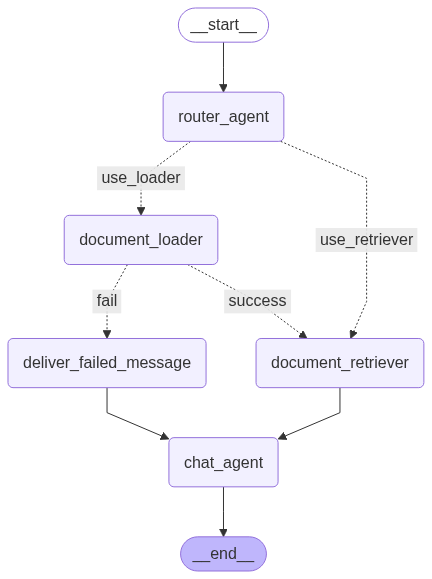

In [20]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

## Chat Function

In [21]:
def chat_loop() -> None:
    print(f"Chat ID: {chat.chat_id}")
    usr_msg: str = input(">> ").strip()

    while usr_msg.lower() != "/exit":
        usr_msg = HumanMessage(usr_msg)
        chat.add_message(usr_msg)
        chat.chat_messages = agent.invoke({"messages": chat.chat_messages})["messages"]
        # for update in agent.stream({"messages": chat.chat_messages}, stream_mode="updates"):
            # print(update)
        ai_msg: AIMessage = chat.chat_messages[-1]
        ai_msg.pretty_print()
        usr_msg: str = input(">> ").strip()
    chat.end_chat()
    chat.remove_unlisted_chats()

In [22]:
chat_loop()

Chat ID: 09913ff7-de58-47da-9bbe-651d40b90def


No relevant docs were retrieved using the relevance score threshold 0.6






[]

================================== Ai Message ==================================

Hello! I am IntelliTube AI, ready to assist you with your research needs. How can I help you today?


2025-07-11 12:39:08.609 | INFO     | __main__:document_loader_node:2 - state["router_response"] = RouterAgentResponse(user_query='what is the llm used in /WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py2', url='/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py2', url_of='document')
2025-07-11 12:39:08.609 | INFO     | __main__:document_loader_node:4 - loader_func = <function load_document at 0x7fd29a3156c0>
2025-07-11 12:39:08.610 | DEBUG    | __main__:load_document:9 - Loading Document...


================================== Ai Message ==================================

I checked the content loaded from `/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py2`, but unfortunately, I don't have information about the specific LLM used in that file.


2025-07-11 12:39:34.922 | INFO     | __main__:document_loader_node:2 - state["router_response"] = RouterAgentResponse(user_query='wha bout now?', url='/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', url_of='document')
2025-07-11 12:39:34.923 | INFO     | __main__:document_loader_node:4 - loader_func = <function load_document at 0x7fd29a3156c0>
2025-07-11 12:39:34.923 | DEBUG    | __main__:load_document:9 - Loading Document...
2025-07-11 12:39:34.924 | INFO     | intellitube.rag:add_documents:96 - Splitting text...
2025-07-11 12:39:34.925 | INFO     | intellitube.rag:add_documents:100 - Adding documents...
No relevant docs were retrieved using the relevance score threshold 0.6






[]

================================== Ai Message ==================================

I checked the content loaded from `/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py`, but unfortunately, I don't have information about the specific LLM used in that file.


2025-07-11 12:39:49.589 | INFO     | __main__:document_loader_node:2 - state["router_response"] = RouterAgentResponse(user_query='what is the llm used in /WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', url='/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', url_of='document')
2025-07-11 12:39:49.589 | INFO     | __main__:document_loader_node:4 - loader_func = <function load_document at 0x7fd29a3156c0>
2025-07-11 12:39:49.590 | DEBUG    | __main__:load_document:9 - Loading Document...
2025-07-11 12:39:49.590 | INFO     | intellitube.rag:add_documents:96 - Splitting text...
2025-07-11 12:39:49.591 | INFO     | intellitube.rag:add_documents:100 - Adding documents...






[Document(metadata={'source': '/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', '_id': '486b5cd97b5749a98a5911fe8aa5375b', '_collection_name': '09913ff7-de58-47da-9bbe-651d40b90def'}, page_content='ai_msg: AIMessage = response_llm.invoke(\n        [system_prompt] + state["messages"]\n    )\n    return {"messages": ai_msg}'), Document(metadata={'source': '/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', '_id': '59d822ff31a24405978c0e5cfcc54f30', '_collection_name': '09913ff7-de58-47da-9bbe-651d40b90def'}, page_content='ai_msg: AIMessage = response_llm.invoke(\n        [system_prompt] + state["messages"]\n    )\n    return {"messages": ai_msg}'), Document(metadata={'source': '/WindowsDrive/DriftResearchProject/intellitube/src/intellitube/chatbot.py', '_id': 'eeece6b378304607a305fb695bdc2001', '_collection_name': '09913ff7-de58-47da-9bbe-651d40b90def'}, page_content='# from intellitube.utils import mermaid2png\n# mermaid2png.draw_p

2025-07-11 12:40:34.263 | INFO     | __main__:document_loader_node:2 - state["router_response"] = RouterAgentResponse(user_query='Okay, but can you tell me how to strem the subgraph outputs from here:', url='https://langchain-ai.github.io/langgraph/how-tos/subgraph/#stream-subgraph-outputs', url_of='website')
2025-07-11 12:40:34.263 | INFO     | __main__:document_loader_node:4 - loader_func = <function load_webpage at 0x7fd29a025580>
2025-07-11 12:40:35.422 | INFO     | intellitube.rag:add_documents:96 - Splitting text...
2025-07-11 12:40:35.423 | INFO     | intellitube.rag:add_documents:100 - Adding documents...
2025-07-11 12:40:35.719 | DEBUG    | __main__:load_webpage:9 - Loading Webpage...






[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/subgraph/#stream-subgraph-outputs', 'title': 'Use subgraphs', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en', '_id': '2926c25bcf7b4191afa113750a8da65b', '_collection_name': '09913ff7-de58-47da-9bbe-651d40b90def'}, page_content="Set subgraphs=True to stream outputs from subgraphs.\n\n```\n((), {'node_1': {'foo': 'hi! foo'}})\n(('node_2:e58e5673-a661-ebb0-70d4-e298a7fc28b7',), {'subgraph_node_1': {'bar': 'bar'}})\n(('node_2:e58e5673-a661-ebb0-70d4-e298a7fc28b7',), {'subgraph_node_2': {'foo': 'hi! foobar'}})\n((), {'node_2': {'foo': 'hi! foobar'}})\n\n\n\n\n\n\n\n\n  Back to top\n\n\n\n\n\n\n\n\n\n\n                Previous\n              \n\n                Overview\n              \n\n\n\n\n\n                Next"), Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/subgraph/#stream-subgraph-outputs', 'title': 'Use subgraphs', 

No relevant docs were retrieved using the relevance score threshold 0.6






[]

================================== Ai Message ==================================

I'm glad I could help! Is there anything else I can assist you with today?
